In [13]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = False
load_gsea = False
load_gsea_heatmap = False
run_umap = True

In [14]:
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
id_ = 'extended'

# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [29]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
import importlib
importlib.reload(ut)

<module 'utils.functions' from '/root/host_home/luca/nb_tumorUMAP/../utils/functions.py'>

In [5]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
time = 'I-IIless'
adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'is_highly_v

In [6]:
adata = adata[(adata.obs.origin == 'tumor_primary')]

In [7]:
adata = adata[np.logical_or(adata.obs.uicc_stage == 'I', adata.obs.uicc_stage == 'II')]

Sadly we must eliminate Guo and Leadder studies becuase they are CD45 (lymphocyte makrer) enriched. Also Goveia is CD31 (endthelial cells) enriched.

In [8]:
adata = adata[np.logical_not(np.logical_or(adata.obs.study == 'Goveia_Carmeliet_2020', adata.obs.study == 'Leader_Merad_2021', adata.obs.study == 'Guo_Zhang_2018'))]

In [9]:
adata.var['ens'] = adata.var.index
adata.var.index = adata.var.feature_name

/tmp/ipykernel_145297/481543411.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ens'] = adata.var.index


In [10]:
adata

AnnData object with n_obs × n_vars = 231773 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'is_highly_va

### Types from infercnv dir

In [11]:
# types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
# types = types.rename(columns={'Unnamed: 0':'barcode_'})
# types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
# types

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


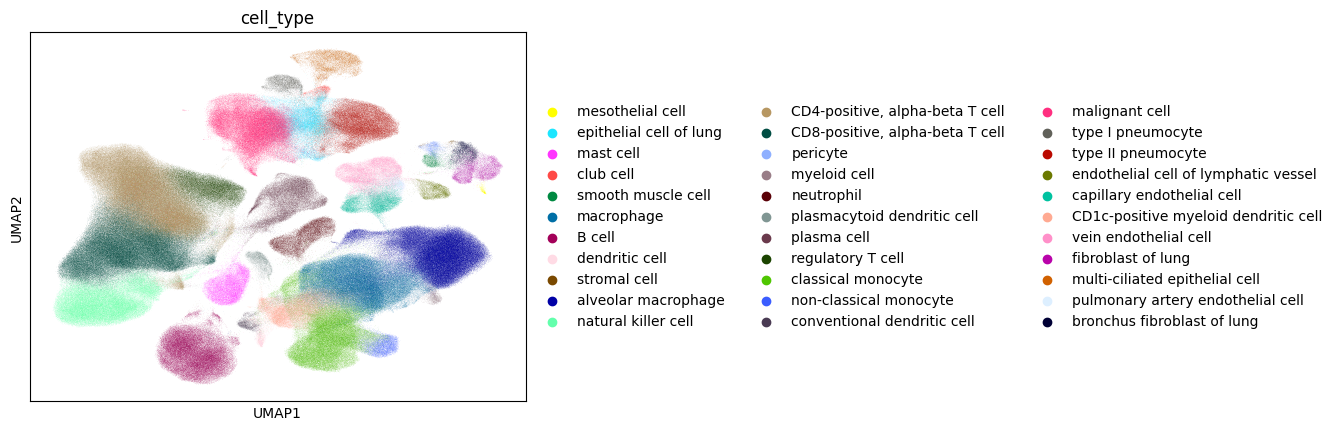

In [23]:
sc.pl.umap(adata, color=['cell_type'])

In [30]:
adata.obs['tumor'] = 'NonTumor'
filter = adata.obs['cell_type_tumor'].str.contains('Tumor')
adata.obs['tumor'][filter]  = adata.obs['cell_type_tumor']

/tmp/ipykernel_53181/1834369284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tumor'][filter]  = adata.obs['cell_type_tumor']


In [33]:
adata_tumor = adata[filter]

In [34]:
sc.tl.umap(adata_tumor)

2024-02-27 00:23:14.953457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 00:23:14.953576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 00:23:15.022686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 00:23:15.160951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 00:23:16.738709: W tensorflow/comp

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


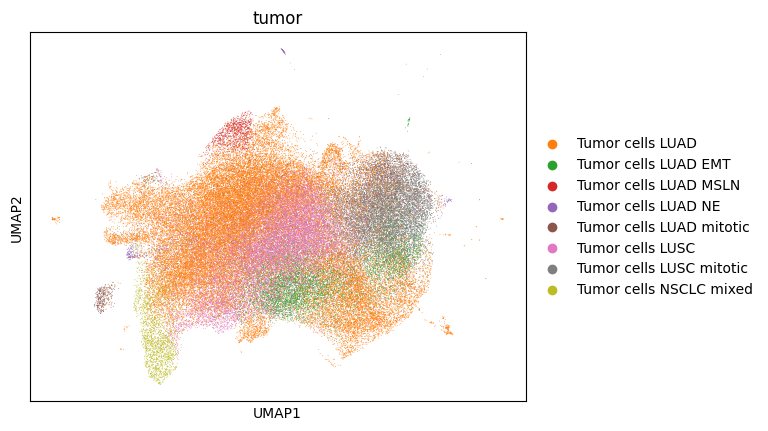

In [35]:
sc.pl.umap(adata_tumor, color=['tumor'])

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


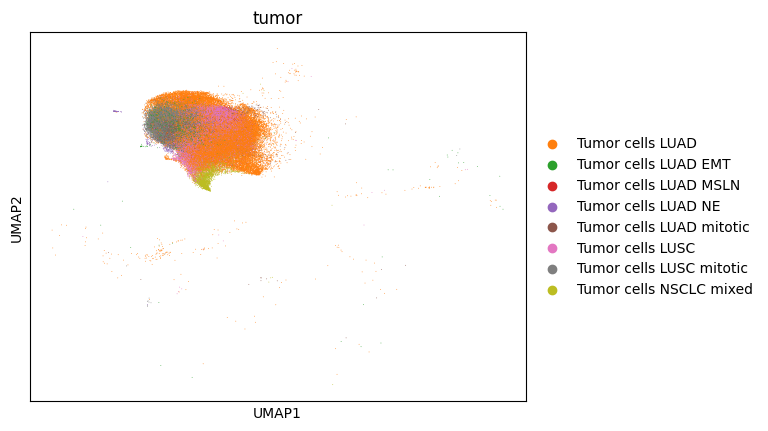

In [32]:
sc.pl.umap(adata[filter], color=['tumor'])

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


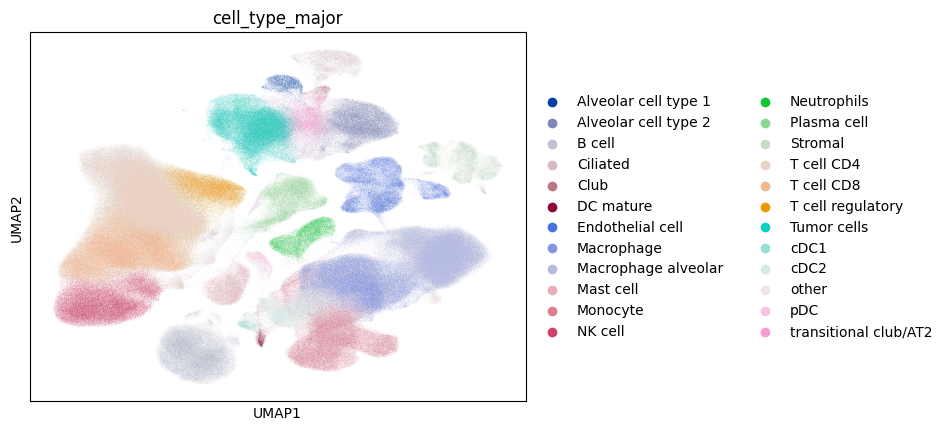

In [26]:
sc.pl.umap(adata, color=['cell_type_'])

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


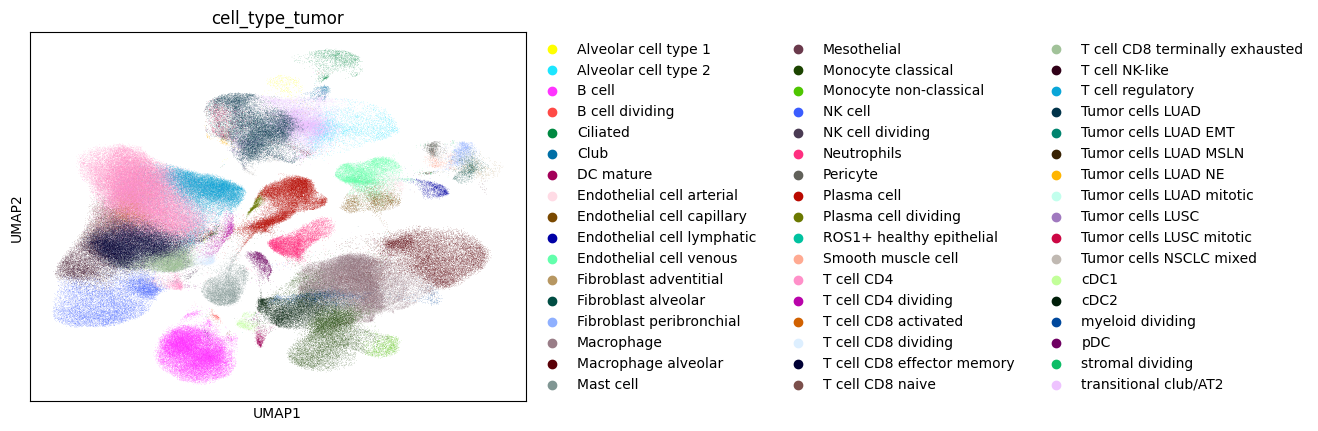

In [51]:
sc.pl.umap(adata, color=['cell_type_tumor'])

In [7]:
# adata.obs['barcode_'] = adata.obs.index
# adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    # how='left')
adata.obs.cell_type = adata.obs.Level_2_transfered_label
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

AttributeError: 'DataFrame' object has no attribute 'Level_2_transfered_label'

### Tumor prediction from ikarus

In [37]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}_preds.csv')
preds

Unnamed: 0 final_pred
0        AAACCCAAGAGCCATG-1_0-1     Normal
1        AAACCCAAGATTAGAC-1_0-1      Tumor
2        AAACCCAAGGTCGCCT-1_0-1     Normal
3        AAACCCAAGTCATTGC-1_0-1      Tumor
4        AAACCCACACGGATCC-1_0-1     Normal
...                         ...        ...
656405  TTTGTCACATCTATGG-1-38-8     Normal
656406  TTTGTCACATGTTGAC-1-38-8     Normal
656407  TTTGTCAGTGTTGGGA-1-38-8     Normal
656408  TTTGTCATCAGTTTGG-1-38-8     Normal
656409  TTTGTCATCTCGGACG-1-38-8     Normal

[656410 rows x 2 columns]

In [53]:
adata_tumor_tissue = adata[adata.obs.origin.isin(['tumor_metastasis', 'tumor_primary']) ]

In [1]:
adata_tumor_tissue.obs['cell_type'].value_counts()

NameError: name 'adata_tumor_tissue' is not defined

In [56]:
adata_tumor_tissue.obs['final_pred'] = list(preds.iloc[:,1])

/tmp/ipykernel_53181/947278710.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tumor_tissue.obs['final_pred'] = list(preds.iloc[:,1])


In [8]:
adata.obs['origin']

0        tumor_primary
1        tumor_primary
2        tumor_primary
3        tumor_primary
4        tumor_primary
             ...      
32068    tumor_primary
32069    tumor_primary
32070    tumor_primary
32071    tumor_primary
32072    tumor_primary
Name: origin, Length: 32073, dtype: category
Categories (1, object): ['tumor_primary']

In [9]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
tumor_primary    32073
Name: count, dtype: int64

In [62]:
adata.layers['counts_length_scaled'].max()

56736550.0

In [61]:
adata.X.max()

7.9258704

In [10]:
adata.layers['counts'] = adata.X

In [11]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [8]:
run_umap

True

In [12]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [13]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [14]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_26886/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
p1t1    2033
p1t2    2253
p1t3    1182
p1t4    1332
p2t1     200
p2t2     166
p3t1    2682
p3t2    2874
p3t3    2711
p4t1    1366
p4t2    1255
p4t3    1547
p5t1    1108
p5t2    2034
p6t1    2471
p6t2    2195
p7t1    2461
p7t2    2203
Name: gsm, dtype: int64

## Marker Genes

We overrride all that hard work we did and just tkae the annotations from LUCA

In [11]:
adata.obs['type_tissue'] = adata.obs['cell_type_tumor']

### Pairwise

With parallel is shit! With 4 groups and 12 jobs it takes 26 min

Without parallel, still runs parallel from nnumpy in the scanpy method. With 4 groups it takes 12 min

TODO: Limit the number of cores this uses https://stackoverflow.com/questions/55746872/how-to-limit-number-of-cpus-used-by-a-python-script-w-o-terminal-or-multiproces

In [12]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
types = adata.obs.type_tissue.cat.categories
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/{time}_{id_}'
key_pair = "rank_genes_groups_pairwise"

In [15]:
%%time
#papermill_description=WILCOXON_DE

if load_wilcoxon:
    adata.uns[key_pair] = np.load(all_path + '_pair.npy', allow_pickle='TRUE').item()
else:
    # TODO Adress this: is sensitive to the population composition, which introduces an element of unpredictability to the marker sets due to variation in cell type abundances
    results = ut.rank_genes_groups_pairwise(adata, 'type_tissue', method='wilcoxon', use_raw=False,
                       groups=valid_types, parallel=False)
    adata.uns[key_pair] = results
    np.save(all_path + '_pair.npy', adata.uns[key_pair])

[('T cell CD4', 'Macrophage'), ('T cell CD4', 'T cell CD8 effector memory'), ('T cell CD4', 'Tumor cells LUAD'), ('T cell CD4', 'B cell'), ('T cell CD4', 'T cell regulatory'), ('T cell CD4', 'Macrophage alveolar'), ('T cell CD4', 'transitional club/AT2'), ('T cell CD4', 'Plasma cell'), ('T cell CD4', 'Neutrophils'), ('T cell CD4', 'T cell CD8 terminally exhausted'), ('T cell CD4', 'cDC2'), ('T cell CD4', 'NK cell'), ('T cell CD4', 'Monocyte classical'), ('T cell CD4', 'Mast cell'), ('T cell CD4', 'T cell NK-like'), ('T cell CD4', 'T cell CD8 activated'), ('T cell CD4', 'T cell CD8 naive'), ('T cell CD4', 'Alveolar cell type 2'), ('T cell CD4', 'Endothelial cell venous'), ('T cell CD4', 'myeloid dividing'), ('T cell CD4', 'Ciliated'), ('T cell CD4', 'Fibroblast peribronchial'), ('T cell CD4', 'Tumor cells LUSC'), ('T cell CD4', 'T cell CD8 dividing'), ('T cell CD4', 'Fibroblast alveolar'), ('T cell CD4', 'T cell CD4 dividing'), ('T cell CD4', 'Tumor cells LUSC mitotic'), ('T cell CD4', 

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/

CPU times: user 10h 9min 40s, sys: 1h 59min 21s, total: 12h 9min 1s
Wall time: 12h 9min 24s


### Summaries

In [16]:
results = adata.uns[key_pair]

In [17]:
def process_gene(group1, pairwise_dict, groups2):
    scores = {}
    genes = next(iter(results.items()))[1]['names']
    comparisons = [(group1, group2) for group2 in groups2 if group1 != group2]
    
    for gene in genes:
        comparison_scores = []
        for comparison in comparisons:
            comp_key = f'{comparison[0]}_vs_{comparison[1]}'
            gene_index = np.where(results[comp_key]['names'] == gene)[0]
            comparison_scores.append(results[comp_key]['scores'][gene_index][0])
        scores[gene] = comparison_scores
    return group1, scores

num_processes = 40

Only Normal

In [30]:
%%time
groups = [ group for group in valid_types if 'Tumor' not in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, groups) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_onlynormal'] = scores_dict

CPU times: user 5min 4s, sys: 2min 21s, total: 7min 26s
Wall time: 13min 46s


Normal all

In [31]:
%%time
groups = [ group for group in valid_types if 'Tumor' not in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_normalall'] = scores_dict

CPU times: user 3min 49s, sys: 2min 16s, total: 6min 6s
Wall time: 13min 42s


Only Tumor

In [32]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, groups) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_onlytumor'] = scores_dict

CPU times: user 32.5 s, sys: 56.3 s, total: 1min 28s
Wall time: 2min 28s


Tumor against all

In [33]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_tumorall'] = scores_dict

CPU times: user 38.2 s, sys: 59.7 s, total: 1min 37s
Wall time: 7min 9s


In [34]:
%%time

regions = ['onlynormal', 'onlytumor', 'tumorall','normalall']
# regions = ['normalall']

for region in regions:
    if load_wilcoxon:
        adata.uns[f'rank_genes_groups_{region}'] = np.load(all_path + f'_{region}.npy', allow_pickle=True).item()
        continue

    regioner = {cell_type: {gene: np.mean(scores) for gene, scores in genes_dict.items()}
                    for cell_type, genes_dict in adata.uns[f'rank_genes_groups_summary_{region}'].items()}
    regioner = {cell_type: sorted(genes.items(), key=lambda k: k[1], reverse=True) for cell_type, genes in regioner.items()}

    types_num = len(regioner)
    genes_num = len(next(iter(results.values()))['names'])
    scores = [[None] * genes_num for _ in range(types_num)]
    names = [[None] * genes_num for _ in range(types_num)]
    
    for i, cell_type in enumerate(regioner.keys()):
        j = 0
        for gene, score in regioner[cell_type]:
            scores[i][j] = score
            names[i][j] = gene
            j += 1

    names_zip = list(zip(*names))
    dtypes = [(typer, float) for typer in regioner.keys()]
    dtypes_names = [(typer, 'O') for typer in regioner.keys()]

    i = 0
    for n_scores in zip(*scores):
        if i==0:
            rank_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
        else:
            temp_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_scores = np.rec.array(np.concatenate((rank_scores, temp_scores)))
    
            temp_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
            rank_names = np.rec.array(np.concatenate((rank_names, temp_names)))
        i += 1

    rec_region = {'params': {'groupby': 'type_tissue', 'reference': region, 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}}
    rec_region['names'] = rank_names
    rec_region['scores'] = rank_scores

    adata.uns[f'rank_genes_groups_{region}'] = rec_region
    np.save(all_path + f'_{region}.npy', adata.uns[f'rank_genes_groups_{region}'])

CPU times: user 34min 29s, sys: 11.1 s, total: 34min 40s
Wall time: 34min 40s


### Plotting

In [12]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # pass
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

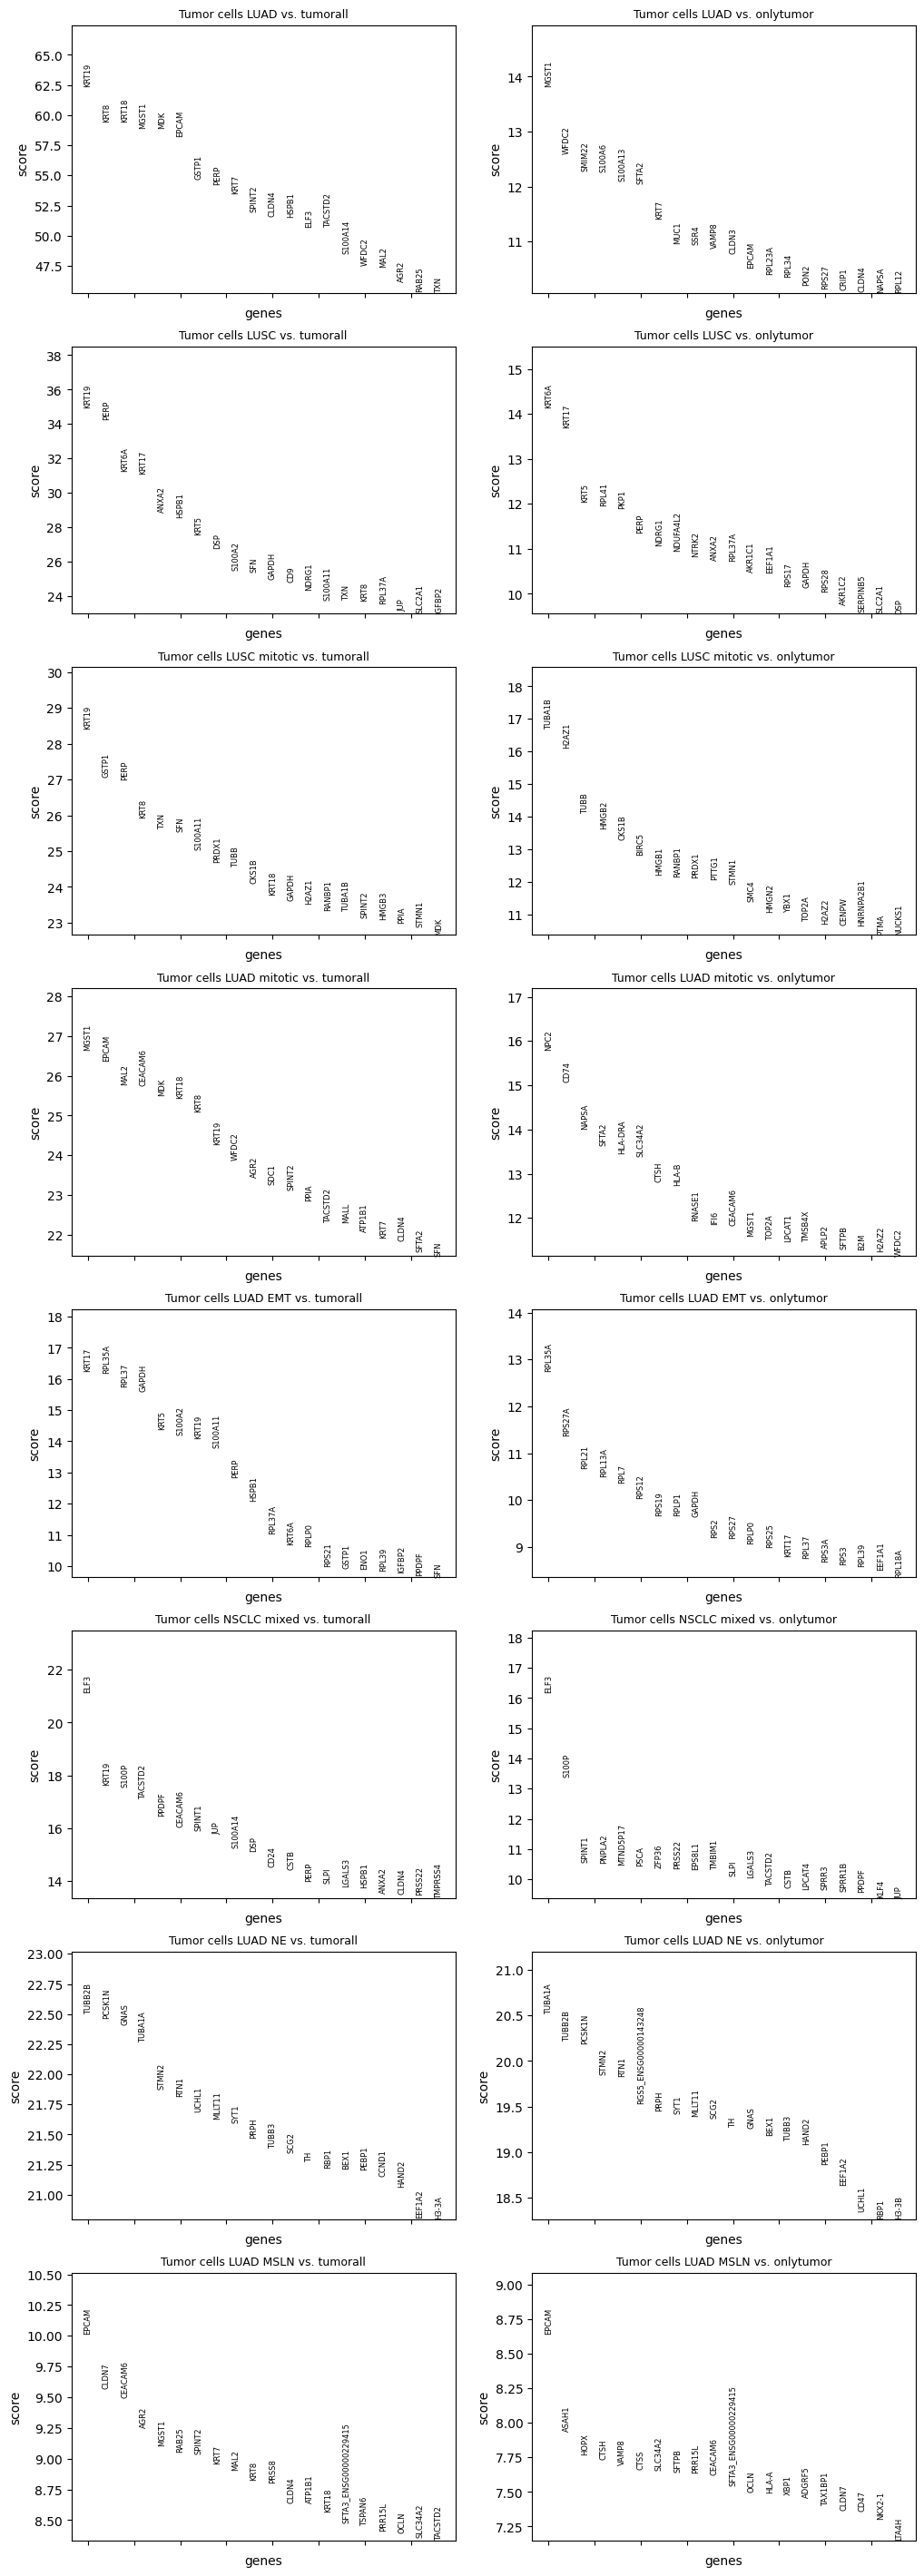

In [13]:
region = 'tumorall'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*(num_types)))
n_genes = 20
for i, type in enumerate(types):
    # tumor_tumor = type + '_TT_Tumor'
    # normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i, 0], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i, 1], sharey=False, key=f'rank_genes_groups_onlytumor', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 21

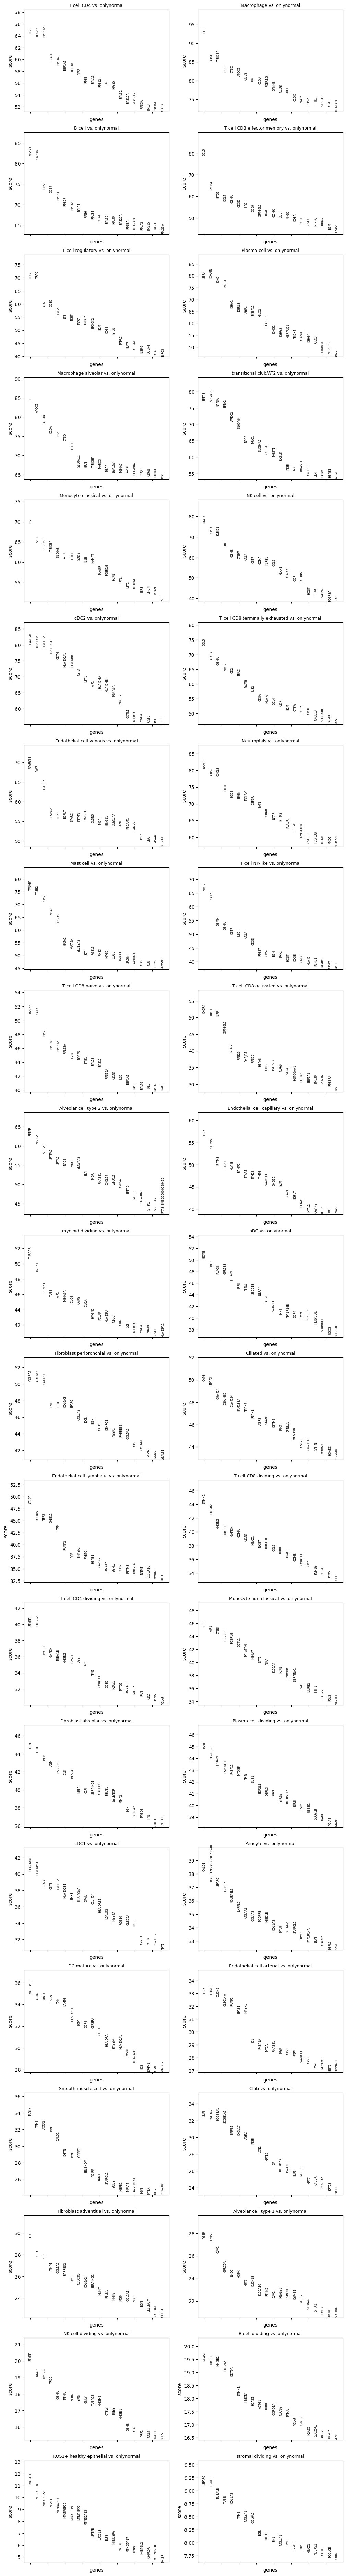

In [14]:
region = 'onlynormal'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types//2, 2, figsize=(12, 4.5*(num_types/2)))
n_genes = 20
for i, type in enumerate(types):
    # tumor_tumor = type + '_TT_Tumor'
    # normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i//2, i%2], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

## Heatmaps

To show heatmap we need the logfold changes also...

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Normal, Airway epithelium_TT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


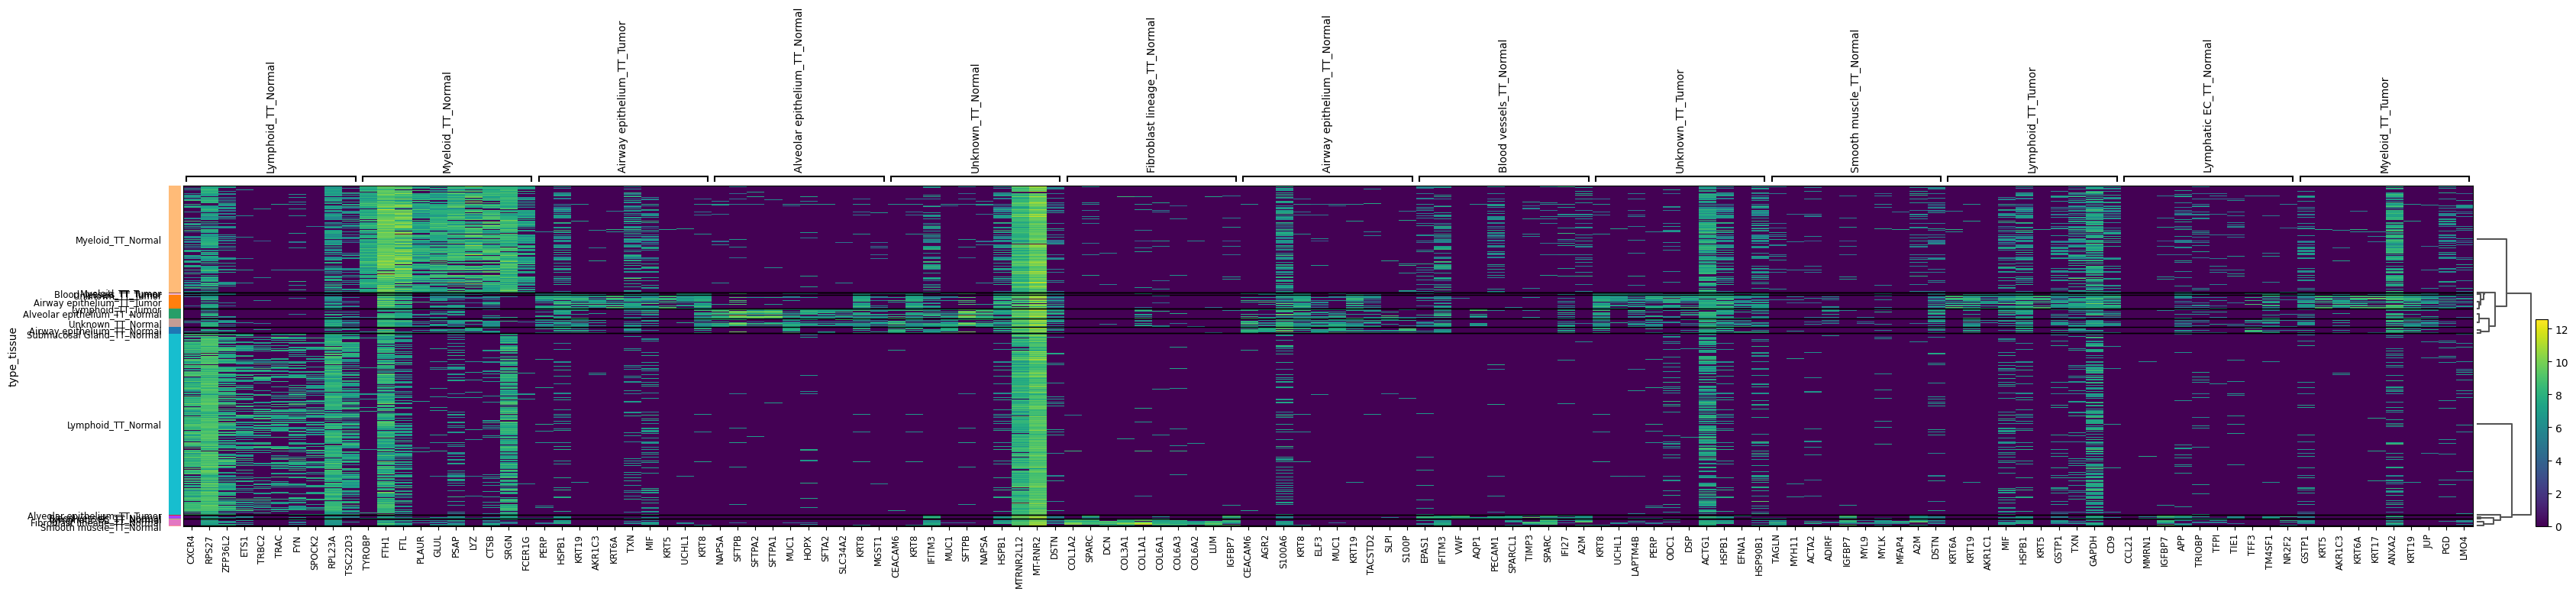

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [35]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [36]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [37]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [38]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str],
                 types: List[str], id_: str, load_gsea: bool = False,
                 key:str = 'rank_gene_groups', gsea_folder:str = 'gseapy_gsea') -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)
    dfs = []

    for type in types:
        ranks = adata.uns[key]
        type_path = type.replace('/','_')
        gsea_path = f'{gsea_folder}/{type_path}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: ranks['scores'][type][i] for i, gene in enumerate(ranks['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [39]:
load_gsea_heatmap=False

In [40]:
%%time
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
combined_dfs = {}

for region in regions:
    gsea_path = f'{gsea_folder}/heatmap_{region}_{time}.csv'
    if load_gsea_heatmap:
        combined_dfs[region] = pd.read_csv(gsea_path, index_col=0)
    else:
        types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
        combined_dfs[region] = get_gseas_df(adata, valid_types, types, id_, load_gsea=False, key=f'rank_genes_groups_{region}')
        combined_dfs[region].to_csv(gsea_path)

/tmp/ipykernel_145297/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:01:24,965 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145297/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
/tmp/ipykernel_145297/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:01:25,956 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145297/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pr

CPU times: user 3min 11s, sys: 18.3 s, total: 3min 29s
Wall time: 48.5 s


In [20]:
combined_dfs[region]

hallmark                  ADIPOGENESIS  ALLOGRAFT_REJECTION  \
cell_type                                                     
Tumor cells LUAD              1.427425            -1.000000   
Tumor cells LUAD EMT         -1.436921            -1.732341   
Tumor cells LUAD MSLN         1.232199             0.582051   
Tumor cells LUAD NE           0.976054            -1.000000   
Tumor cells LUAD mitotic      1.279479            -1.000000   
Tumor cells LUSC              1.158618            -2.233014   
Tumor cells LUSC mitotic      1.277306            -1.000000   
Tumor cells NSCLC mixed      -1.295838            -2.269435   

hallmark                  ANDROGEN_RESPONSE  ANGIOGENESIS  APICAL_JUNCTION  \
cell_type                                                                    
Tumor cells LUAD                   1.377219      0.779840         1.076396   
Tumor cells LUAD EMT              -0.982018     -1.024163        -0.825369   
Tumor cells LUAD MSLN              1.240068      0.739106         1.031748   
Tumor cells LUAD NE                0.965439      0.637755         0.822112   
Tumor cells LUAD mitotic           1.310614      0.756934         1.165411   
Tumor cells LUSC                   1.312774      0.979367         1.486984   
Tumor cells LUSC mitotic           1.217011      0.775322         1.135805   
Tumor cells NSCLC mixed            1.338794     -1.086856         1.462723   

hallmark                  APICAL_SURFACE  APOPTOSIS  BILE_ACID_METABOLISM  \
cell_type                                                                   
Tumor cells LUAD                0.993326   1.142516              1.089029   
Tumor cells LUAD EMT            1.028310  -1.539516             -1.024214   
Tumor cells LUAD MSLN           1.148092   1.104845              1.030464   
Tumor cells LUAD NE             0.750704   0.623480              0.898593   
Tumor cells LUAD mitotic        1.037019   1.139523              1.030525   
Tumor cells LUSC                1.315976   1.043658              0.842619   
Tumor cells LUSC mitotic        1.016863   0.937856              1.070996   
Tumor cells NSCLC mixed         1.528753   1.254254             -0.732171   

hallmark                  CHOLESTEROL_HOMEOSTASIS  COAGULATION  ...  \
cell_type                                                       ...   
Tumor cells LUAD                         1.440776     1.153406  ...   
Tumor cells LUAD EMT                     1.181055    -1.159440  ...   
Tumor cells LUAD MSLN                    1.209993     1.097822  ...   
Tumor cells LUAD NE                      0.866625    -1.000000  ...   
Tumor cells LUAD mitotic                 1.289934     1.208725  ...   
Tumor cells LUSC                         1.566226     0.940594  ...   
Tumor cells LUSC mitotic                 1.408112     0.803736  ...   
Tumor cells NSCLC mixed                  1.521813     1.148969  ...   

hallmark                  PROTEIN_SECRETION  REACTIVE_OXYGEN_SPECIES_PATHWAY  \
cell_type                                                                      
Tumor cells LUAD                   1.581167                         1.396195   
Tumor cells LUAD EMT              -1.063994                        -0.930858   
Tumor cells LUAD MSLN              1.467571                         1.099912   
Tumor cells LUAD NE                1.210543                         0.830095   
Tumor cells LUAD mitotic           1.493410                         1.274831   
Tumor cells LUSC                   1.533996                         1.308853   
Tumor cells LUSC mitotic           1.405052                         1.491861   
Tumor cells NSCLC mixed            1.656824                        -1.605513   

hallmark                  SPERMATOGENESIS  TGF_BETA_SIGNALING  \
cell_type                                                       
Tumor cells LUAD                 1.043092            0.968740   
Tumor cells LUAD EMT             1.118106           -1.417703   
Tumor cells LUAD MSLN            0.979601    

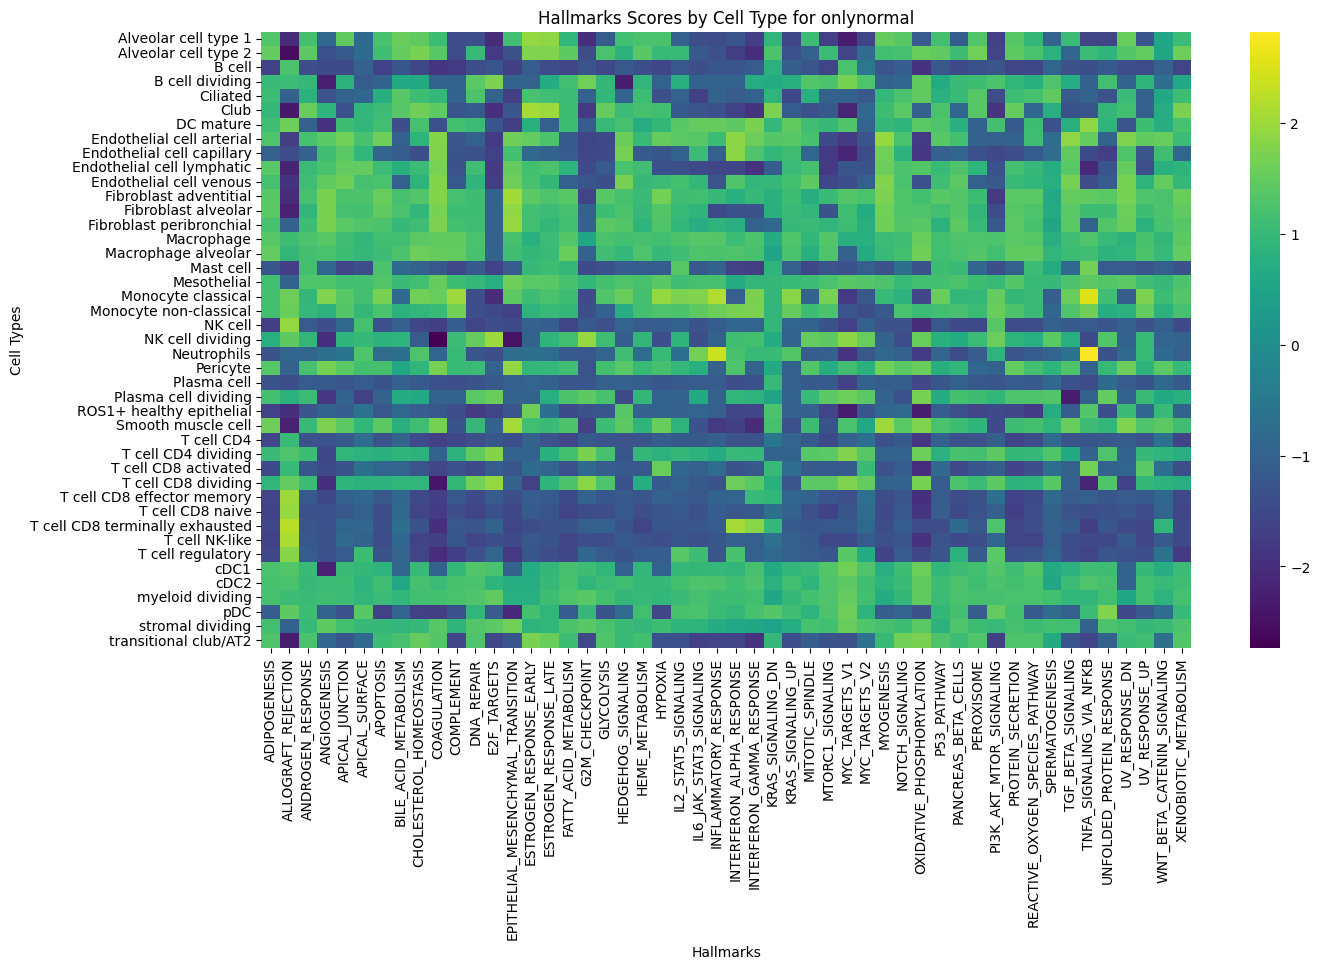

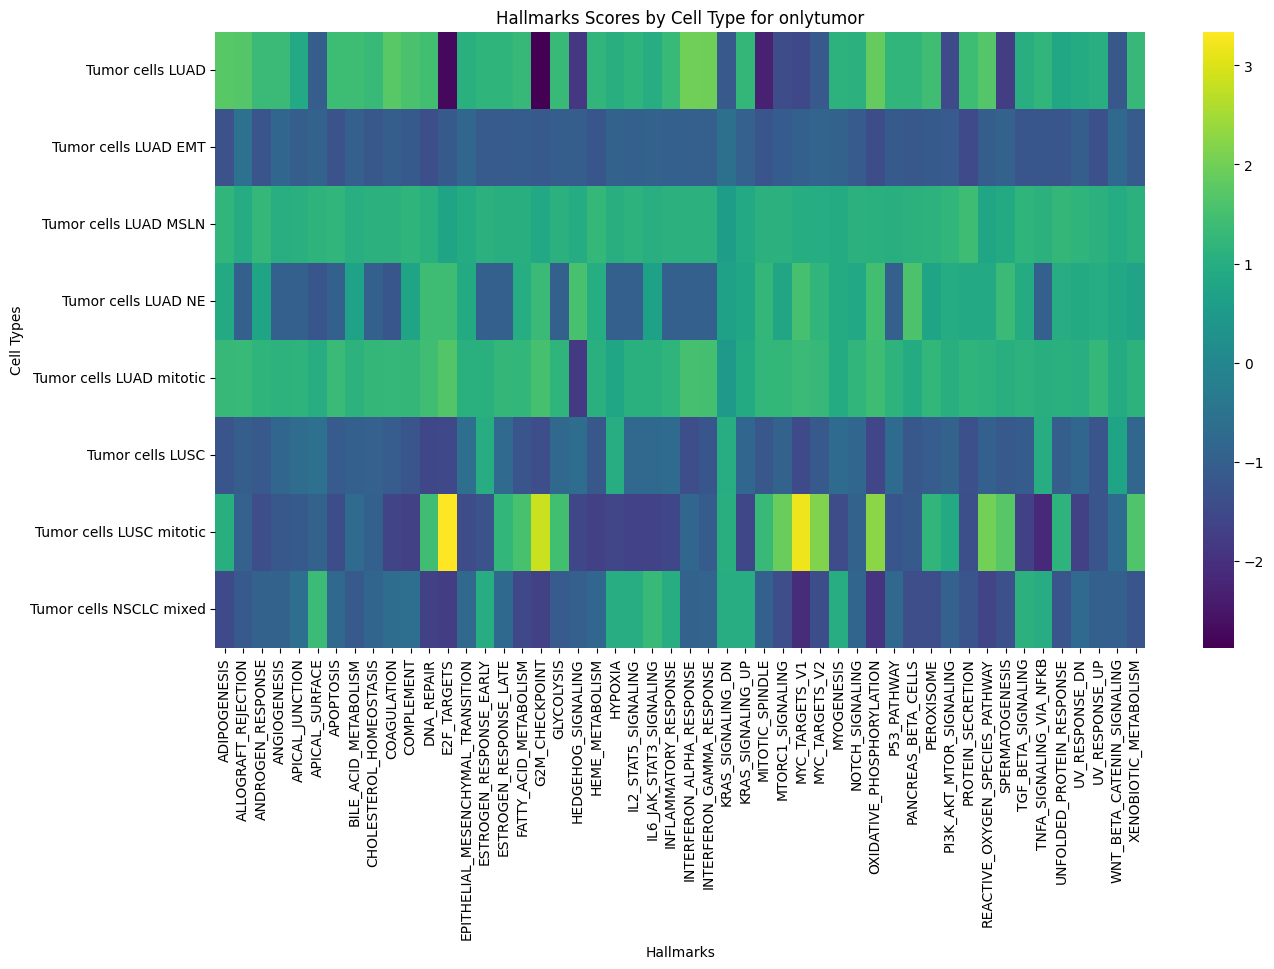

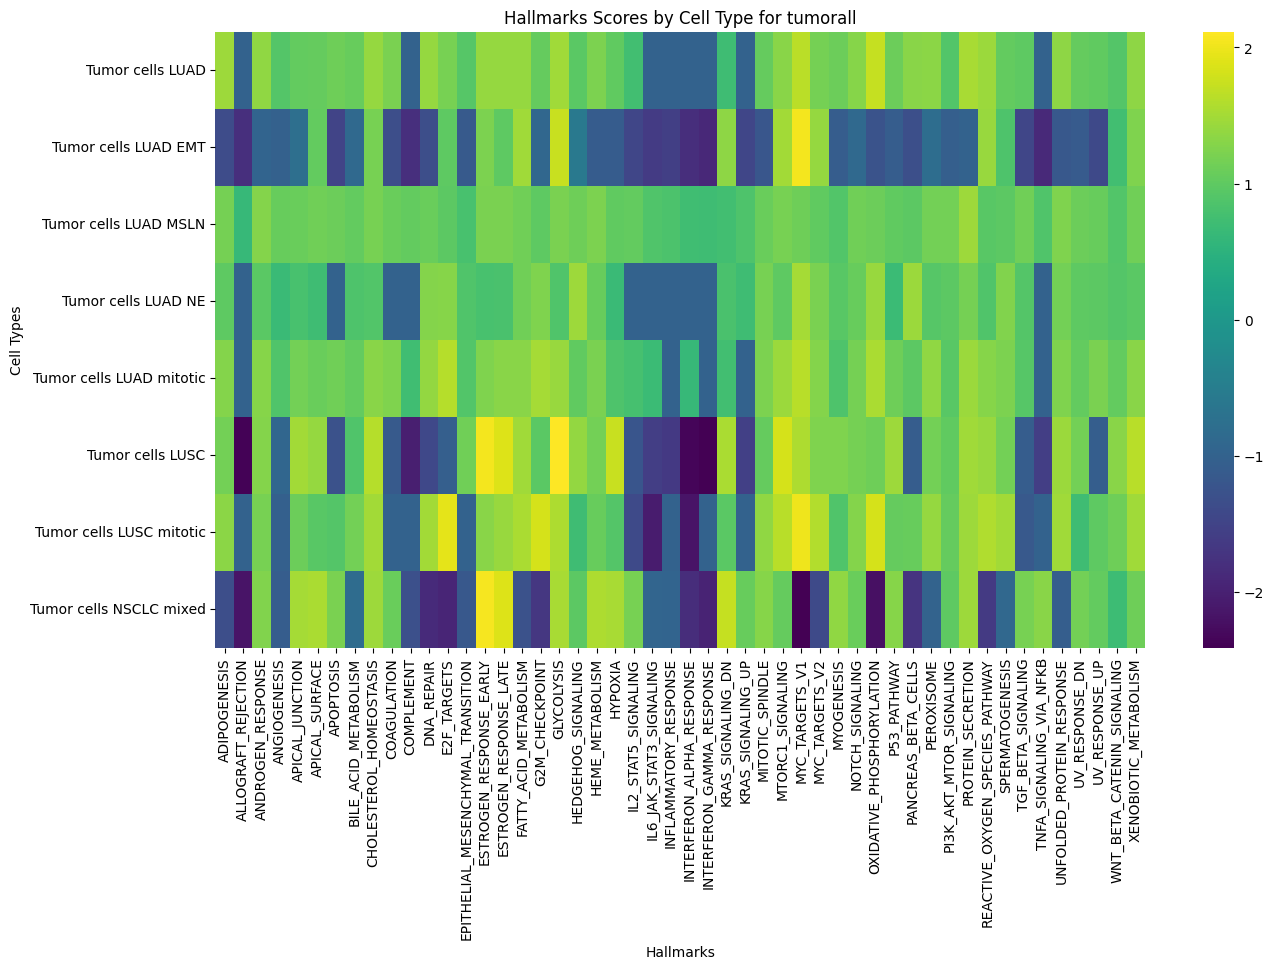

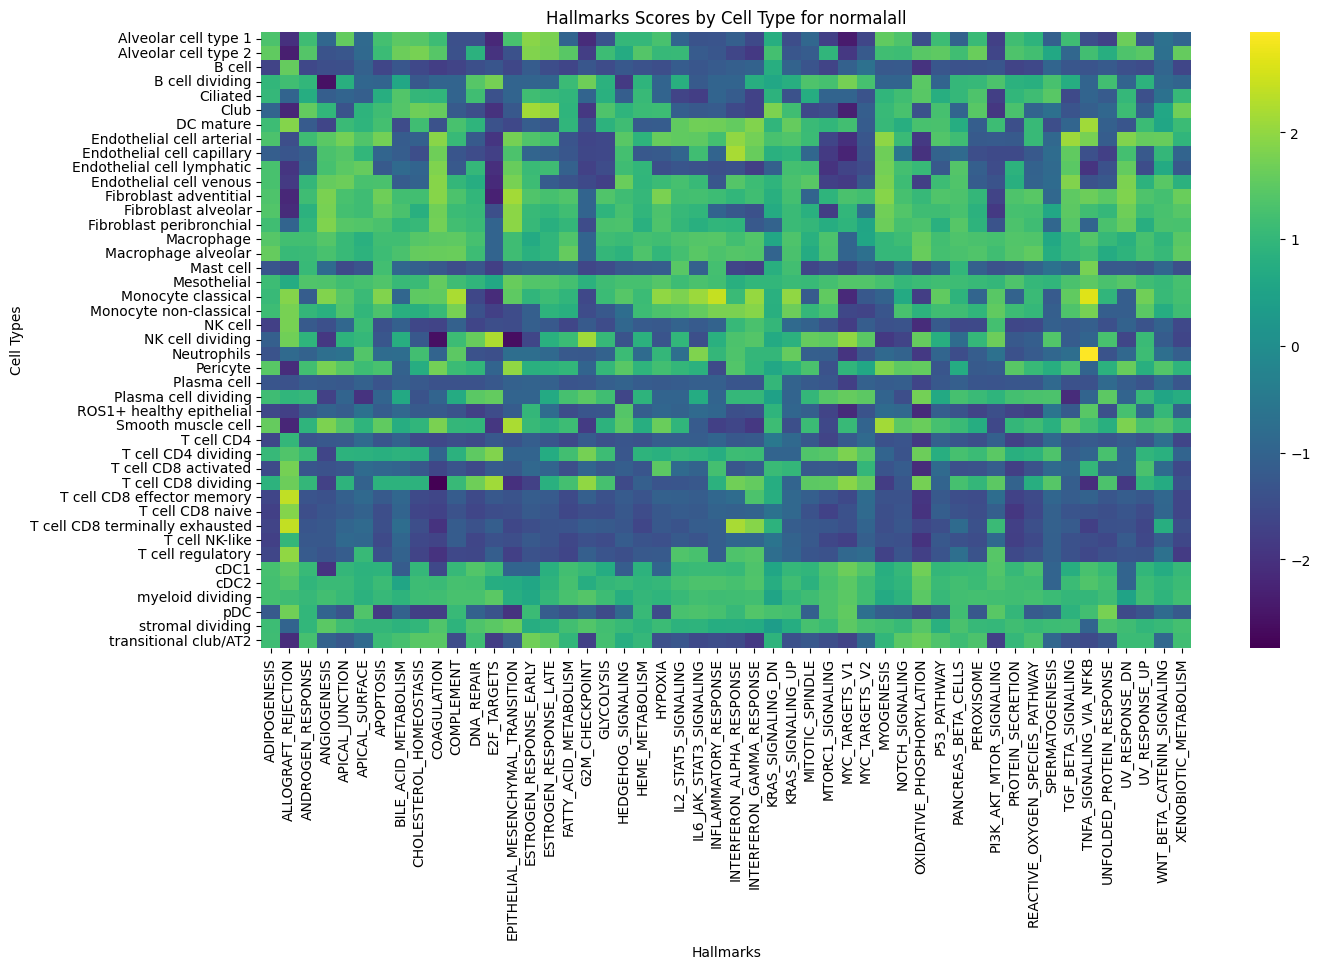

In [41]:
# Plotting the heatmap
# combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']
for region in regions:
    plt.figure(figsize=(15, 8))
    sns.heatmap(combined_dfs[region], cmap='viridis')
    plt.title(f'Hallmarks Scores by Cell Type for {region}')
    plt.xlabel('Hallmarks')
    plt.ylabel('Cell Types')
    plt.show()